# Load modules and dataset

In [ ]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn
!pip install scikeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer, precision_score, recall_score, log_loss
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import MobileBertTokenizer, TFMobileBertModel
from transformers import AutoTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, Bidirectional
from sklearn.model_selection import StratifiedKFold, cross_validate
import torch
import requests
from tensorflow.keras import activations, optimizers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
path = '/content/drive/MyDrive/FakeNewsNet/final.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,title,label
0,Jax Taylor recalls his 'near-death' experience...,true
1,Bobbi Kristina Brown,true
2,'Shahs of Sunset' Star Mercedes 'MJ' Javid Is ...,true
3,Kourtney Kardashian Needs Scott Disick to Be '...,true
4,Celine Dion Sings Rihanna Song When Asked Abou...,true


In [ ]:
label_encoder = LabelEncoder()
label = df['label']
labels_encoded = label_encoder.fit_transform(label)
df['label'] = labels_encoded
df.head()

,title,label
0,Jax Taylor recalls his 'near-death' experience...,1
1,Bobbi Kristina Brown,1
2,'Shahs of Sunset' Star Mercedes 'MJ' Javid Is ...,1
3,Kourtney Kardashian Needs Scott Disick to Be '...,1
4,Celine Dion Sings Rihanna Song When Asked Abou...,1


In [ ]:

import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('punkt')

import re

def replace_with_synonyms(text):
    tokens = nltk.word_tokenize(text)
    synonyms = []

    for token in tokens:
        if re.match(r'\w+', token):
            synsets = wordnet.synsets(token)
            if synsets:
                lemma_names = synsets[0].lemma_names()
                if lemma_names:
                    synonyms.append(lemma_names[0])
                else:
                    synonyms.append(token)
            else:
                synonyms.append(token)
        else:
            synonyms.append(token)

    return ' '.join(synonyms)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
minority_samples = df[df['label'] == 0]

synthetic_samples = minority_samples['title'].apply(replace_with_synonyms)

synthetic_data = pd.DataFrame({'title': synthetic_samples, 'label': 0})

df = pd.concat([df, synthetic_data], ignore_index=True)

In [ ]:
label_counts = df['label'].value_counts()

# Print the label distribution
print(label_counts)

1    17441
0    11510
Name: label, dtype: int64


# Fine Tune DistilBERT

In [ ]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(df['title'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, df['label'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['title'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['title'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 3
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/3
11580/11580 [==============================] - 599s 49ms/step - loss: 0.3625 - accuracy: 0.8449
Epoch 2/3
11580/11580 [==============================] - 568s 49ms/step - loss: 0.2474 - accuracy: 0.9011
Epoch 3/3
11580/11580 [==============================] - 553s 48ms/step - loss: 0.1840 - accuracy: 0.9316


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

2896/2896 [==============================] - 69s 23ms/step - loss: 0.1282 - accuracy: 0.9596


In [ ]:
print(benchmarks)

{'loss': 0.1282486468553543, 'accuracy': 0.9595924615859985}


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


# Create Embeddings

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

#### FakeNewsNet Title Embeddings DistilBERT

In [ ]:
#το συγκεκριμένο τμήμα είναι χρονοβόρο οπότε καλό θα ήταν να χρησιμοποιούνται τα αποθηκευμένα αρχεία που έχουμε δημιουργήσει (embeddings.npy,labels.npy)
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['title'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 28951/28951 [56:19<00:00,  8.57it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsNet/embeddings_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsNet/labels_title_distilbert.npy', labels)

# Statements - Titles

## **CNN-DistilBERT**

In [ ]:
embeddings = np.load('/content/drive/MyDrive/FakeNewsNet/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/FakeNewsNet/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([23160, 768, 1])

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels,epochs=10, batch_size=16)

Epoch 1/10
1448/1448 [==============================] - 17s 6ms/step - loss: 0.1278 - accuracy: 0.9568
Epoch 2/10
1448/1448 [==============================] - 10s 7ms/step - loss: 0.1073 - accuracy: 0.9655
Epoch 3/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.1063 - accuracy: 0.9662
Epoch 4/10
1448/1448 [==============================] - 10s 7ms/step - loss: 0.1016 - accuracy: 0.9663
Epoch 5/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1014 - accuracy: 0.9663
Epoch 6/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1008 - accuracy: 0.9669
Epoch 7/10
1448/1448 [==============================] - 10s 7ms/step - loss: 0.0995 - accuracy: 0.9679
Epoch 8/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.0980 - accuracy: 0.9674
Epoch 9/10
1448/1448 [==============================] - 10s 7ms/step - loss: 0.0968 - accuracy: 0.9673
Epoch 10/10
1448/1448 [==============================] - 9s 6ms/step - loss: 

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

181/181 [==============================] - 1s 2ms/step
Test Accuracy: 0.9678812026977539
Test F1 Score: 0.9736767619586754
Test Recall: 0.9786628733997155
Precision: 0.9687411996620671


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

181/181 [==============================] - 0s 2ms/step
[[2165  111]
 [  75 3440]]


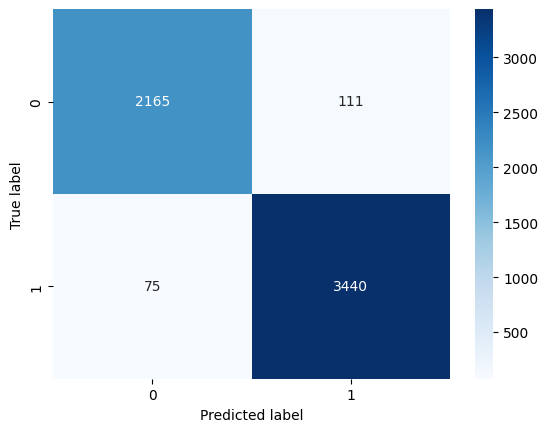

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    print(classification_report(test_labels, y_pred))

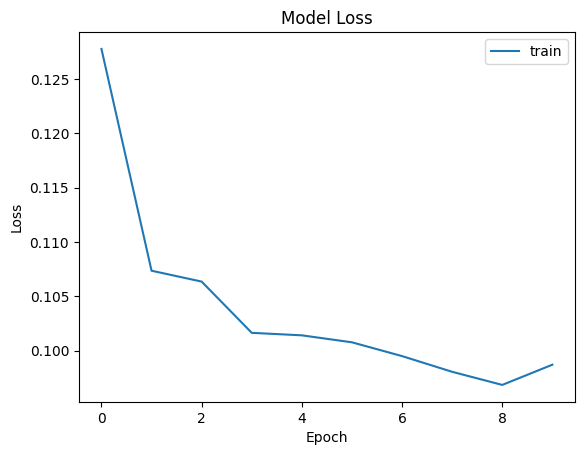

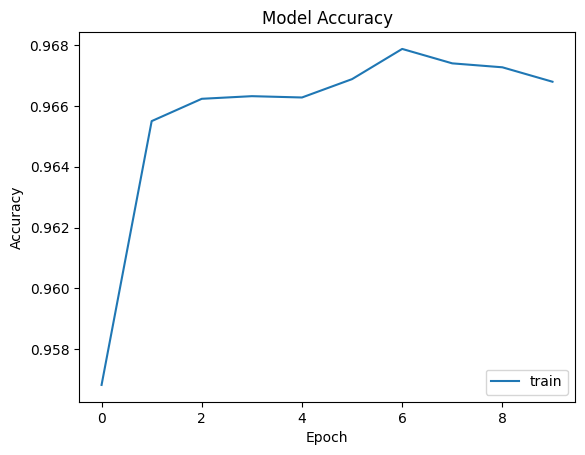

181/181 [==============================] - 0s 2ms/step


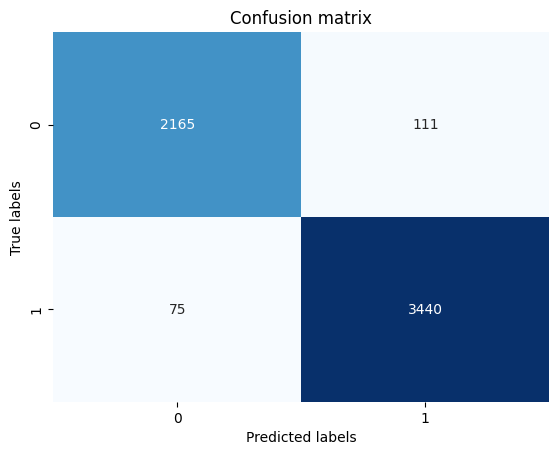

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2276
           1       0.97      0.98      0.97      3515

    accuracy                           0.97      5791
   macro avg       0.97      0.96      0.97      5791
weighted avg       0.97      0.97      0.97      5791



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1158/1158 [==============================] - 10s 6ms/step - loss: 0.1308 - accuracy: 0.9567
Epoch 2/10
1158/1158 [==============================] - 6s 5ms/step - loss: 0.1019 - accuracy: 0.9677
Epoch 3/10
1158/1158 [==============================] - 11s 10ms/step - loss: 0.1007 - accuracy: 0.9670
Epoch 4/10
1158/1158 [==============================] - 7s 6ms/step - loss: 0.1009 - accuracy: 0.9683
Epoch 5/10
1158/1158 [==============================] - 6s 6ms/step - loss: 0.0980 - accuracy: 0.9668
Epoch 6/10
1158/1158 [==============================] - 6s 5ms/step - loss: 0.0965 - accuracy: 0.9674
Epoch 7/10
1158/1158 [==============================] - 6s 5ms/step - loss: 0.0970 - accuracy: 0.9685
Epoch 8/10
1158/1158 [==============================] - 7s 6ms/step - loss: 0.0989 - accuracy: 0.9681
Epoch 9/10
1158/1158 [==============================] - 5s 5ms/step - loss: 0.0960 - accuracy: 0.9688
Epoch 10/10
290/290 [==============================] - 1s 3ms/step
Epoch 1/10
1

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.97 (+/- 0.00)
Cross-Validation Precision: 0.97 (+/- 0.01)
Cross-Validation Loss: 0.10 (+/- 0.01)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.97 (+/- 0.00)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
1448/1448 [==============================] - 28s 15ms/step - loss: 0.1039 - accuracy: 0.9647
Epoch 2/10
1448/1448 [==============================] - 21s 14ms/step - loss: 0.0984 - accuracy: 0.9672
Epoch 3/10
1448/1448 [==============================] - 20s 14ms/step - loss: 0.0954 - accuracy: 0.9677
Epoch 4/10
1448/1448 [==============================] - 23s 16ms/step - loss: 0.0950 - accuracy: 0.9670
Epoch 5/10
1448/1448 [==============================] - 21s 14ms/step - loss: 0.0945 - accuracy: 0.9671
Epoch 6/10
1448/1448 [==============================] - 21s 14ms/step - loss: 0.0936 - accuracy: 0.9675
Epoch 7/10
1448/1448 [==============================] - 20s 14ms/step - loss: 0.0929 - accuracy: 0.9674
Epoch 8/10
1448/1448 [==============================] - 20s 14ms/step - loss: 0.0929 - accuracy: 0.9674
Epoch 9/10
1448/1448 [==============================] - 22s 15ms/step - loss: 0.0924 - accuracy: 0.9679
Epoch 10/10
1448/1448 [==============================] - 22s 15m

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

181/181 - 2s - loss: 0.0945 - accuracy: 0.9684 - 2s/epoch - 12ms/step
181/181 [==============================] - 2s 7ms/step
Test Accuracy: 0.9683992266654968
Test F1 Score: 0.9740535942152276
Test Recall: 0.9772403982930299
Precision: 0.970887507066139


In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)         

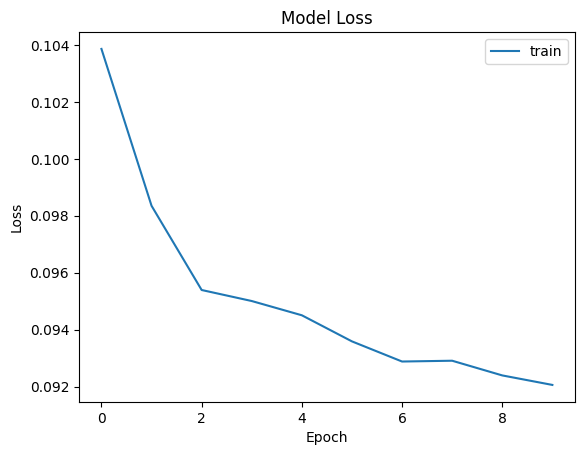

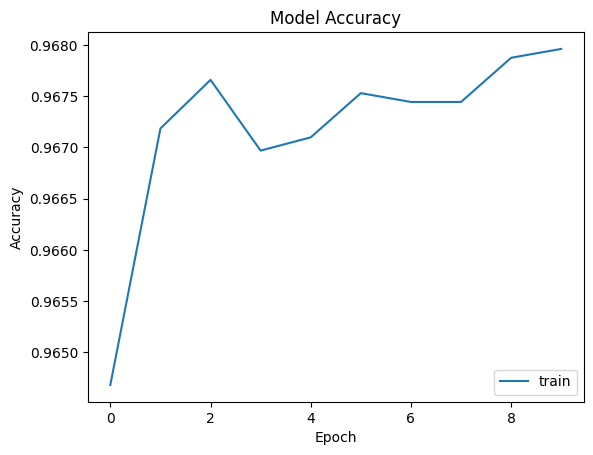

181/181 [==============================] - 1s 7ms/step


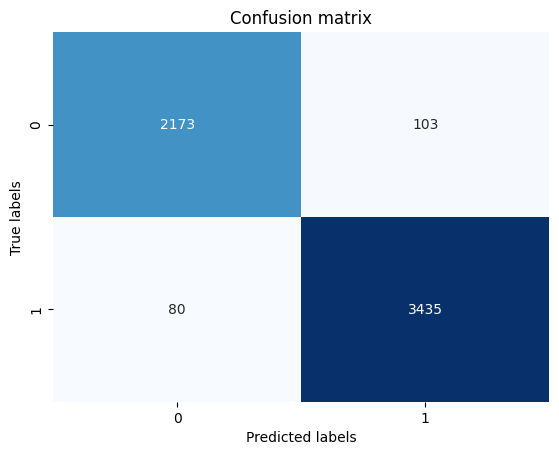

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2276
           1       0.97      0.98      0.97      3515

    accuracy                           0.97      5791
   macro avg       0.97      0.97      0.97      5791
weighted avg       0.97      0.97      0.97      5791



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1158/1158 [==============================] - 18s 11ms/step - loss: 0.1065 - accuracy: 0.9631
Epoch 2/10
1158/1158 [==============================] - 13s 12ms/step - loss: 0.0982 - accuracy: 0.9663
Epoch 3/10
1158/1158 [==============================] - 13s 12ms/step - loss: 0.0973 - accuracy: 0.9661
Epoch 4/10
1158/1158 [==============================] - 14s 12ms/step - loss: 0.0969 - accuracy: 0.9668
Epoch 5/10
1158/1158 [==============================] - 14s 12ms/step - loss: 0.0951 - accuracy: 0.9673
Epoch 6/10
1158/1158 [==============================] - 14s 12ms/step - loss: 0.0945 - accuracy: 0.9670
Epoch 7/10
1158/1158 [==============================] - 13s 12ms/step - loss: 0.0937 - accuracy: 0.9671
Epoch 8/10
1158/1158 [==============================] - 13s 11ms/step - loss: 0.0936 - accuracy: 0.9677
Epoch 9/10
1158/1158 [==============================] - 13s 11ms/step - loss: 0.0927 - accuracy: 0.9669
Epoch 10/10
290/290 [==============================] - 2s 6ms/st

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.97 (+/- 0.01)
Cross-Validation Precision: 0.97 (+/- 0.02)
Cross-Validation Loss: 0.10 (+/- 0.02)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.97 (+/- 0.01)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
1448/1448 [==============================] - 15s 8ms/step - loss: 0.1174 - accuracy: 0.9619
Epoch 2/10
1448/1448 [==============================] - 11s 8ms/step - loss: 0.1034 - accuracy: 0.9645
Epoch 3/10
1448/1448 [==============================] - 12s 8ms/step - loss: 0.0999 - accuracy: 0.9664
Epoch 4/10
1448/1448 [==============================] - 12s 8ms/step - loss: 0.0982 - accuracy: 0.9677
Epoch 5/10
1448/1448 [==============================] - 11s 7ms/step - loss: 0.1001 - accuracy: 0.9674
Epoch 6/10
1448/1448 [==============================] - 11s 8ms/step - loss: 0.0976 - accuracy: 0.9665
Epoch 7/10
1448/1448 [==============================] - 12s 8ms/step - loss: 0.0957 - accuracy: 0.9680
Epoch 8/10
1448/1448 [==============================] - 12s 8ms/step - loss: 0.0959 - accuracy: 0.9675
Epoch 9/10
1448/1448 [==============================] - 11s 7ms/step - loss: 0.0960 - accuracy: 0.9668
Epoch 10/10
1448/1448 [==============================] - 11s 8ms/step - l

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

181/181 - 1s - loss: 0.0949 - accuracy: 0.9675 - 1s/epoch - 6ms/step
181/181 [==============================] - 1s 4ms/step
Test Accuracy: 0.9675358533859253
Test F1 Score: 0.9732650739476678
Test Recall: 0.9735419630156472
Precision: 0.9729883423372192


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

181/181 [==============================] - 1s 4ms/step
[[2181   95]
 [  93 3422]]


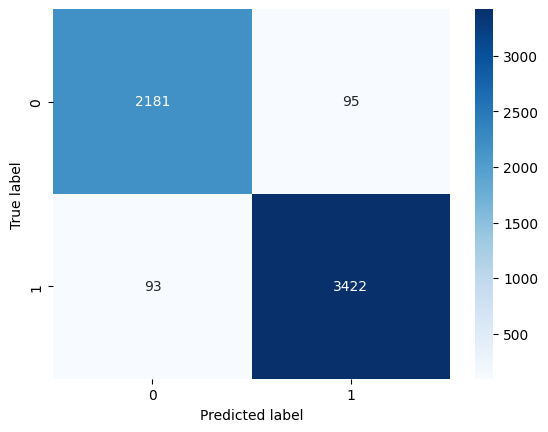

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1158/1158 [==============================] - 11s 6ms/step - loss: 0.1154 - accuracy: 0.9634
Epoch 2/10
1158/1158 [==============================] - 8s 7ms/step - loss: 0.1027 - accuracy: 0.9670
Epoch 3/10
1158/1158 [==============================] - 7s 6ms/step - loss: 0.0995 - accuracy: 0.9668
Epoch 4/10
1158/1158 [==============================] - 8s 7ms/step - loss: 0.0997 - accuracy: 0.9676
Epoch 5/10
1158/1158 [==============================] - 7s 6ms/step - loss: 0.0973 - accuracy: 0.9673
Epoch 6/10
1158/1158 [==============================] - 8s 7ms/step - loss: 0.0970 - accuracy: 0.9681
Epoch 7/10
1158/1158 [==============================] - 7s 6ms/step - loss: 0.0971 - accuracy: 0.9670
Epoch 8/10
1158/1158 [==============================] - 8s 7ms/step - loss: 0.0962 - accuracy: 0.9678
Epoch 9/10
1158/1158 [==============================] - 7s 6ms/step - loss: 0.0947 - accuracy: 0.9688
Epoch 10/10
290/290 [==============================] - 1s 3ms/step
Epoch 1/10
115

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.97 (+/- 0.00)
Cross-Validation Precision: 0.97 (+/- 0.01)
Cross-Validation Loss: 0.10 (+/- 0.02)
Cross-Validation Recall: 0.97 (+/- 0.02)
Cross-Validation F1 Score: 0.97 (+/- 0.00)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
1448/1448 [==============================] - 8s 4ms/step - loss: 0.1013 - accuracy: 0.9642
Epoch 2/10
1448/1448 [==============================] - 7s 5ms/step - loss: 0.0950 - accuracy: 0.9674
Epoch 3/10
1448/1448 [==============================] - 6s 4ms/step - loss: 0.0932 - accuracy: 0.9673
Epoch 4/10
1448/1448 [==============================] - 6s 4ms/step - loss: 0.0923 - accuracy: 0.9676
Epoch 5/10
1448/1448 [==============================] - 7s 5ms/step - loss: 0.0912 - accuracy: 0.9681
Epoch 6/10
1448/1448 [==============================] - 6s 4ms/step - loss: 0.0903 - accuracy: 0.9681
Epoch 7/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.0897 - accuracy: 0.9690
Epoch 8/10
1448/1448 [==============================] - 6s 4ms/step - loss: 0.0893 - accuracy: 0.9692
Epoch 9/10
1448/1448 [==============================] - 7s 5ms/step - loss: 0.0891 - accuracy: 0.9690
Epoch 10/10
1448/1448 [==============================] - 6s 4ms/step - loss: 0.088

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

181/181 [==============================] - 0s 2ms/step
Test Accuracy: 0.9677085280418396
Test F1 Score: 0.9733807829181496
Test Recall: 0.9726884779516358
Precision: 0.9740740740740741


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 12256)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                784448    
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
_______________________________________________

181/181 [==============================] - 0s 2ms/step
[[2185   91]
 [  96 3419]]


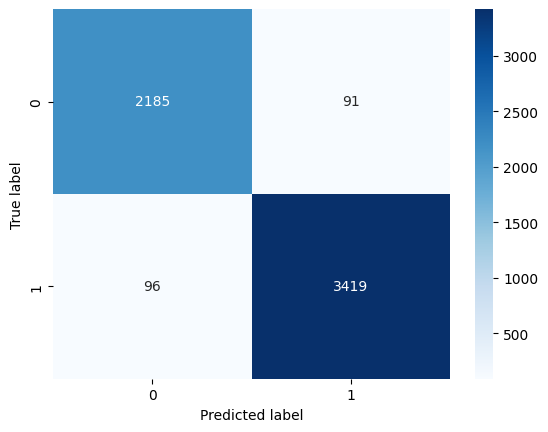

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

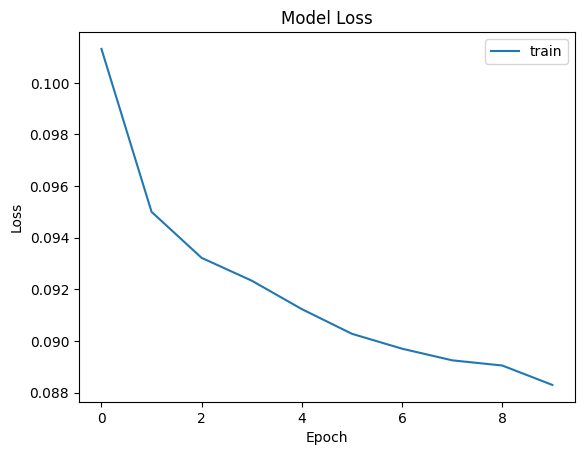

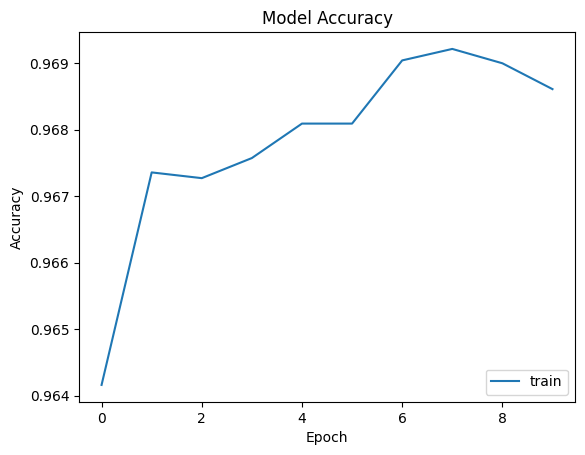

181/181 [==============================] - 0s 2ms/step


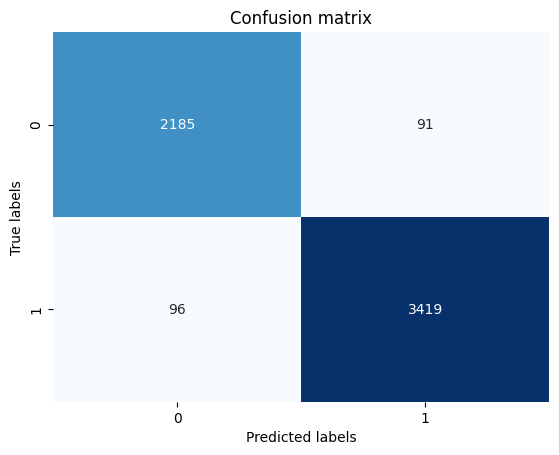

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2276
           1       0.97      0.97      0.97      3515

    accuracy                           0.97      5791
   macro avg       0.97      0.97      0.97      5791
weighted avg       0.97      0.97      0.97      5791



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1158/1158 [==============================] - 6s 5ms/step - loss: 0.1029 - accuracy: 0.9650
Epoch 2/10
1158/1158 [==============================] - 4s 3ms/step - loss: 0.0974 - accuracy: 0.9669
Epoch 3/10
1158/1158 [==============================] - 4s 3ms/step - loss: 0.0955 - accuracy: 0.9672
Epoch 4/10
1158/1158 [==============================] - 4s 3ms/step - loss: 0.0942 - accuracy: 0.9680
Epoch 5/10
1158/1158 [==============================] - 5s 4ms/step - loss: 0.0923 - accuracy: 0.9684
Epoch 6/10
1158/1158 [==============================] - 4s 3ms/step - loss: 0.0927 - accuracy: 0.9682
Epoch 7/10
1158/1158 [==============================] - 4s 3ms/step - loss: 0.0913 - accuracy: 0.9689
Epoch 8/10
1158/1158 [==============================] - 5s 4ms/step - loss: 0.0907 - accuracy: 0.9690
Epoch 9/10
1158/1158 [==============================] - 5s 4ms/step - loss: 0.0897 - accuracy: 0.9684
Epoch 10/10
290/290 [==============================] - 1s 2ms/step
Epoch 1/10
1158

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.97 (+/- 0.00)
Cross-Validation Precision: 0.96 (+/- 0.01)
Cross-Validation Loss: 0.09 (+/- 0.01)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.97 (+/- 0.00)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
1448/1448 [==============================] - 38s 21ms/step - loss: 0.2543 - accuracy: 0.9639
Epoch 2/10
1448/1448 [==============================] - 30s 21ms/step - loss: 0.1041 - accuracy: 0.9661
Epoch 3/10
1448/1448 [==============================] - 31s 21ms/step - loss: 0.1009 - accuracy: 0.9665
Epoch 4/10
1448/1448 [==============================] - 28s 19ms/step - loss: 0.0998 - accuracy: 0.9669
Epoch 5/10
1448/1448 [==============================] - 28s 19ms/step - loss: 0.0989 - accuracy: 0.9668
Epoch 6/10
1448/1448 [==============================] - 28s 19ms/step - loss: 0.0974 - accuracy: 0.9671
Epoch 7/10
1448/1448 [==============================] - 28s 19ms/step - loss: 0.0970 - accuracy: 0.9679
Epoch 8/10
1448/1448 [==============================] - 29s 20ms/step - loss: 0.0962 - accuracy: 0.9677
Epoch 9/10
1448/1448 [==============================] - 29s 20ms/step - loss: 0.0953 - accuracy: 0.9679
Epoch 10/10
1448/1448 [==============================] - 27s 18m

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

181/181 - 3s - loss: 0.1088 - accuracy: 0.9689 - 3s/epoch - 14ms/step
181/181 [==============================] - 2s 9ms/step
Test Accuracy: 0.9689173102378845
Test F1 Score: 0.9744897959183674
Test Recall: 0.9780938833570413
Precision: 0.9709121717029088


In [ ]:
model5.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                     

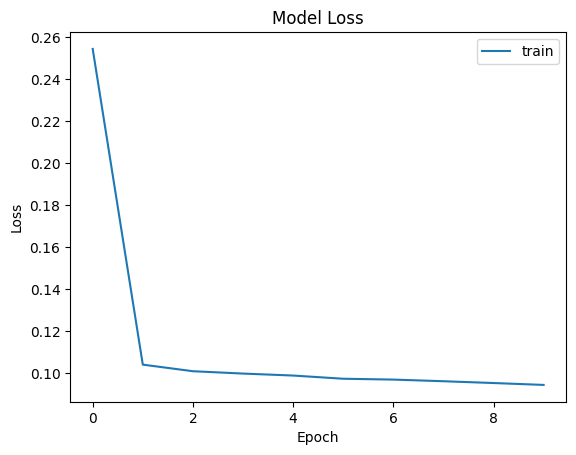

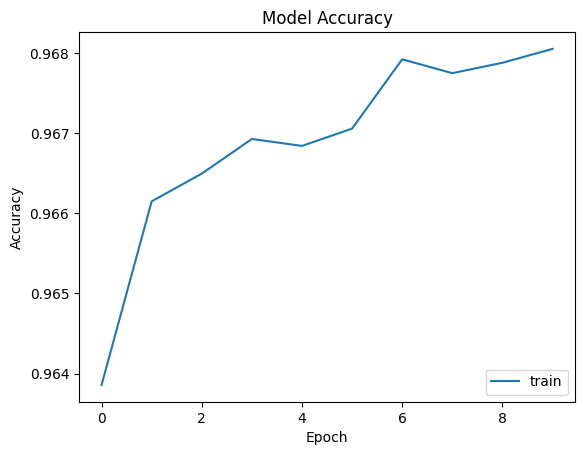

181/181 [==============================] - 2s 11ms/step


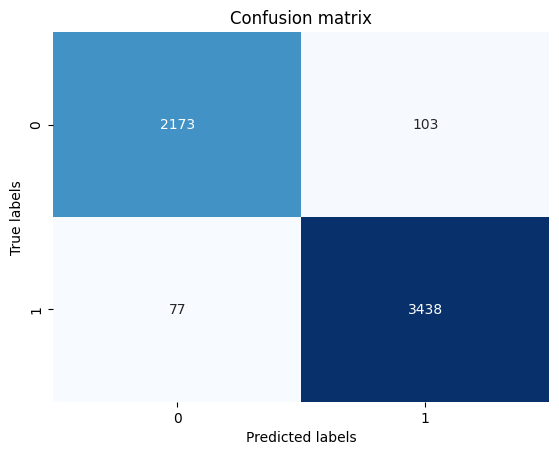

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2276
           1       0.97      0.98      0.97      3515

    accuracy                           0.97      5791
   macro avg       0.97      0.97      0.97      5791
weighted avg       0.97      0.97      0.97      5791



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1158/1158 [==============================] - 25s 17ms/step - loss: 0.2841 - accuracy: 0.9642
Epoch 2/10
1158/1158 [==============================] - 21s 18ms/step - loss: 0.1014 - accuracy: 0.9668
Epoch 3/10
1158/1158 [==============================] - 20s 17ms/step - loss: 0.0983 - accuracy: 0.9684
Epoch 4/10
1158/1158 [==============================] - 21s 18ms/step - loss: 0.0974 - accuracy: 0.9671
Epoch 5/10
1158/1158 [==============================] - 23s 20ms/step - loss: 0.0948 - accuracy: 0.9677
Epoch 6/10
1158/1158 [==============================] - 21s 18ms/step - loss: 0.0947 - accuracy: 0.9684
Epoch 7/10
1158/1158 [==============================] - 23s 19ms/step - loss: 0.0934 - accuracy: 0.9684
Epoch 8/10
1158/1158 [==============================] - 22s 19ms/step - loss: 0.0928 - accuracy: 0.9680
Epoch 9/10
1158/1158 [==============================] - 22s 19ms/step - loss: 0.0923 - accuracy: 0.9683
Epoch 10/10
290/290 [==============================] - 4s 13ms/s

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.97 (+/- 0.01)
Cross-Validation Precision: 0.97 (+/- 0.01)
Cross-Validation Loss: 0.10 (+/- 0.02)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.97 (+/- 0.01)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
1448/1448 [==============================] - 11s 6ms/step - loss: 0.2629 - accuracy: 0.9585
Epoch 2/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1202 - accuracy: 0.9653
Epoch 3/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.1207 - accuracy: 0.9658
Epoch 4/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1142 - accuracy: 0.9668
Epoch 5/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1153 - accuracy: 0.9667
Epoch 6/10
1448/1448 [==============================] - 8s 5ms/step - loss: 0.1144 - accuracy: 0.9673
Epoch 7/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1119 - accuracy: 0.9671
Epoch 8/10
1448/1448 [==============================] - 8s 6ms/step - loss: 0.1121 - accuracy: 0.9661
Epoch 9/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.1105 - accuracy: 0.9684
Epoch 10/10
1448/1448 [==============================] - 9s 6ms/step - loss: 0.10

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

181/181 [==============================] - 1s 2ms/step
Test Accuracy: 0.966672420501709
Test F1 Score: 0.9725813325756499
Test Recall: 0.9738264580369843
Precision: 0.9713393870601589


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_73 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_74 (MaxPoolin  (None, 5, 128)         

181/181 [==============================] - 0s 2ms/step
[[2175  101]
 [  92 3423]]


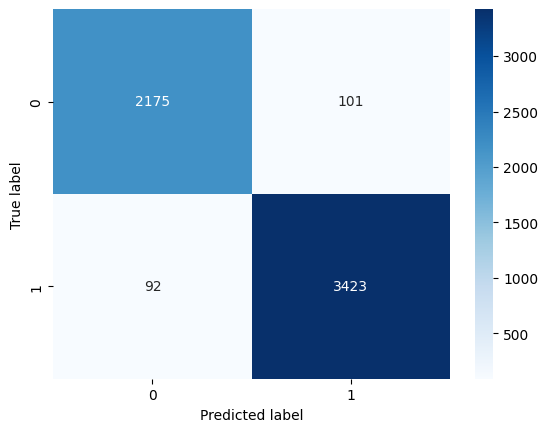

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

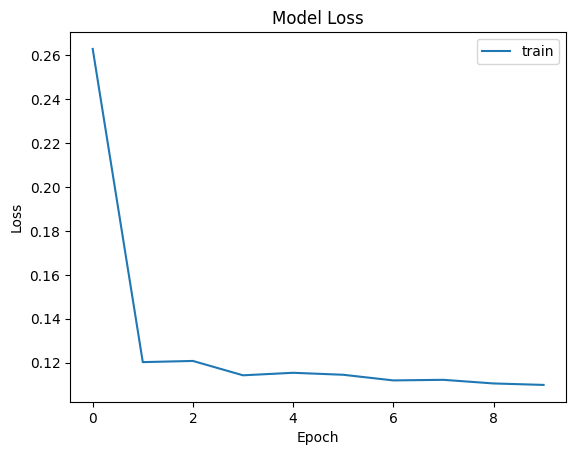

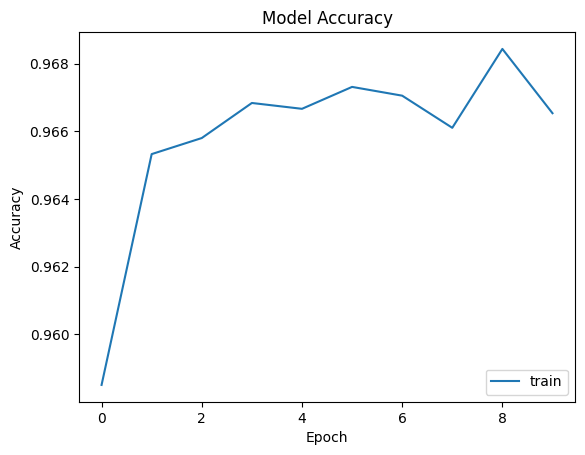

181/181 [==============================] - 0s 2ms/step


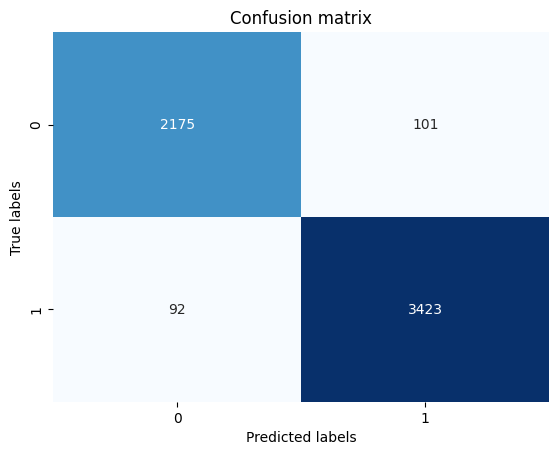

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2276
           1       0.97      0.97      0.97      3515

    accuracy                           0.97      5791
   macro avg       0.97      0.96      0.97      5791
weighted avg       0.97      0.97      0.97      5791



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
1158/1158 [==============================] - 24s 6ms/step - loss: 0.2959 - accuracy: 0.9557
Epoch 2/10
1158/1158 [==============================] - 5s 4ms/step - loss: 0.1239 - accuracy: 0.9652
Epoch 3/10
1158/1158 [==============================] - 6s 5ms/step - loss: 0.1192 - accuracy: 0.9665
Epoch 4/10
1158/1158 [==============================] - 5s 5ms/step - loss: 0.1166 - accuracy: 0.9667
Epoch 5/10
1158/1158 [==============================] - 5s 5ms/step - loss: 0.1114 - accuracy: 0.9672
Epoch 6/10
1158/1158 [==============================] - 7s 6ms/step - loss: 0.1114 - accuracy: 0.9673
Epoch 7/10
1158/1158 [==============================] - 5s 5ms/step - loss: 0.1122 - accuracy: 0.9669
Epoch 8/10
1158/1158 [==============================] - 6s 5ms/step - loss: 0.1101 - accuracy: 0.9674
Epoch 9/10
1158/1158 [==============================] - 6s 5ms/step - loss: 0.1079 - accuracy: 0.9684
Epoch 10/10
290/290 [==============================] - 1s 2ms/step
Epoch 1/10
115

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.97 (+/- 0.00)
Cross-Validation Precision: 0.96 (+/- 0.01)
Cross-Validation Loss: 0.10 (+/- 0.02)
Cross-Validation Recall: 0.98 (+/- 0.01)
Cross-Validation F1 Score: 0.97 (+/- 0.00)
